# Time Frequency Analysis of Neural Signals

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.io as sio

### Taking average signal from all trials

In [38]:
def avg_trial(data):
    data = np.array(data)
    data = np.mean(data, axis=0)
    return data

### Plotting all trials

In [39]:
# plotting all trials
def plot_trails(wave,time):
    plt.figure(figsize=(25,10))
    for i in range(0,len(wave)):
        plt.plot(time, wave[i])
    plt.show()

### Computing FFT and Power spectra

In [40]:
def compute_spectra(wave,fs,time):
    # gives DFT sample frequencies
    freqs = np.fft.fftfreq(time.size, 1/fs)

    # ignoring half the values( all negative values of freqs) since they are complex conjugate of others
    pos = freqs > 0

    # fft values for wave
    fft_vals = np.fft.fft(wave)

    # true theoritical fft
    fft_theo = 2.0*abs(fft_vals/fs)

    # power spectra
    ps = 2.0*(np.abs(fft_vals/time.size)**2)
    print(np.sum(ps[pos]))
    return freqs,fft_vals,pos,fft_theo,ps

### Function for ploting FFT and power spectra

In [41]:
def plot_spectra(freqs,fft_vals,pos,fft_theo,ps):
    f, axis=plt.subplots(1,3,figsize=(20,7))
    f.suptitle("Frequency Spectrum", fontsize=15)
    axis[0].plot(freqs,abs(fft_vals))
    axis[0].set_title("FFT")
    axis[0].set_xlabel("Frequency")
    axis[0].set_ylabel("Amplitude")
    axis[1].plot(freqs[pos],fft_theo[pos])
    axis[1].set_title("Theoritical FFT")
    axis[1].set_xlabel("Frequency")
    axis[1].set_ylabel("Amplitude")
    axis[2].plot(freqs[pos],ps[pos])
    axis[2].set_title("Power Spectrum/ Frequency Spectrum")
    axis[2].set_xlabel("Frequency")
    axis[2].set_ylabel("Amplitude")

In [42]:
def logscale_spectrum_plot(freqs,fft_vals,pos,fft_theo,ps):
    f, axis=plt.subplots(1,3,figsize=(20,7))
    f.suptitle("log scale Frequency Spectrum", fontsize=15)
    axis[0].semilogy(freqs,abs(fft_vals))
    axis[0].set_title("FFT")
    axis[0].set_xlabel("Frequency")
    axis[0].set_ylabel("log(Amplitude)")
    axis[1].semilogy(freqs[pos],fft_theo[pos])
    axis[1].set_title("Theoritical FFT")
    axis[1].set_xlabel("Frequency")
    axis[1].set_ylabel("log(Amplitude)")
    axis[2].semilogy(freqs[pos],ps[pos])
    axis[2].set_title("Power Spectrum/ Frequency Spectrum")
    axis[2].set_xlabel("Frequency")
    axis[2].set_ylabel("log(power)")

### Calculating STFT

In [43]:
# implement STFT 
def stft(wave,fs):
    no_per_seg = int(fs* 0.5)
    no_overlap = int(no_per_seg * 0.5)
    freq,time,power = signal.spectrogram(wave, fs, nperseg=no_per_seg, noverlap=no_overlap, nfft=no_per_seg, detrend=False, scaling='density', axis=-1)
    power = np.abs(power)
    return freq,time,power

### Plotting STFT

In [44]:
# plot STFT
def plot_stft(freqs,times,power):
    plt.figure(figsize=(10, 10))
    plt.pcolormesh(times, freqs, power, vmin=0, vmax=1, shading='gouraud')
    plt.title('TFR using STFT')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

### Calculating Multitaper transform

In [45]:
def multitaper_transform(wave, fs):
    # time-bandwidth product (bw_prod) and number of tapers (no_taper)
    bw_prod = 4
    no_taper = 2*bw_prod - 1

    no_per_seg = int(fs / bw_prod)
    no_overlap = int(no_per_seg / 2)

    # Define the tapers using the Slepian sequence
    tapers = signal.windows.dpss(no_per_seg, no_taper, return_ratios=False)
    freq, time, power = signal.spectrogram(wave, fs=fs, window=tapers, nperseg=no_per_seg, noverlap=no_overlap, mode='complex')
    power = np.abs(power)

    return freq ,time , power

### Plotting TFR using Multitaper

In [46]:
def plot_multitaper(time,freqs,power):
    plt.figure(figsize=(10, 10))
    # Plot the spectrogram
    plt.pcolormesh(time, freqs, power, vmin=0, vmax=1, shading='gouraud')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()
    plt.show()

## Condition1.mat dataset

In [47]:
mat_contents1 = sio.loadmat('Condition1.mat')
mat1 = mat_contents1['final_mat_condition3']
# print(type(mat_contents1)) 
# mat_contents1.items()
print(mat1.shape)

(40, 769)


In [48]:
# separating trials
separate_signals = []
for i in range(0,mat1.shape[0]):
    separate_signals.append(mat1[i,:])

In [49]:
fs = 512 # sampling frequency
end = 1  # end time
start = -0.5 # start time
time = np.arange(start,end+1/fs, step=1/fs)

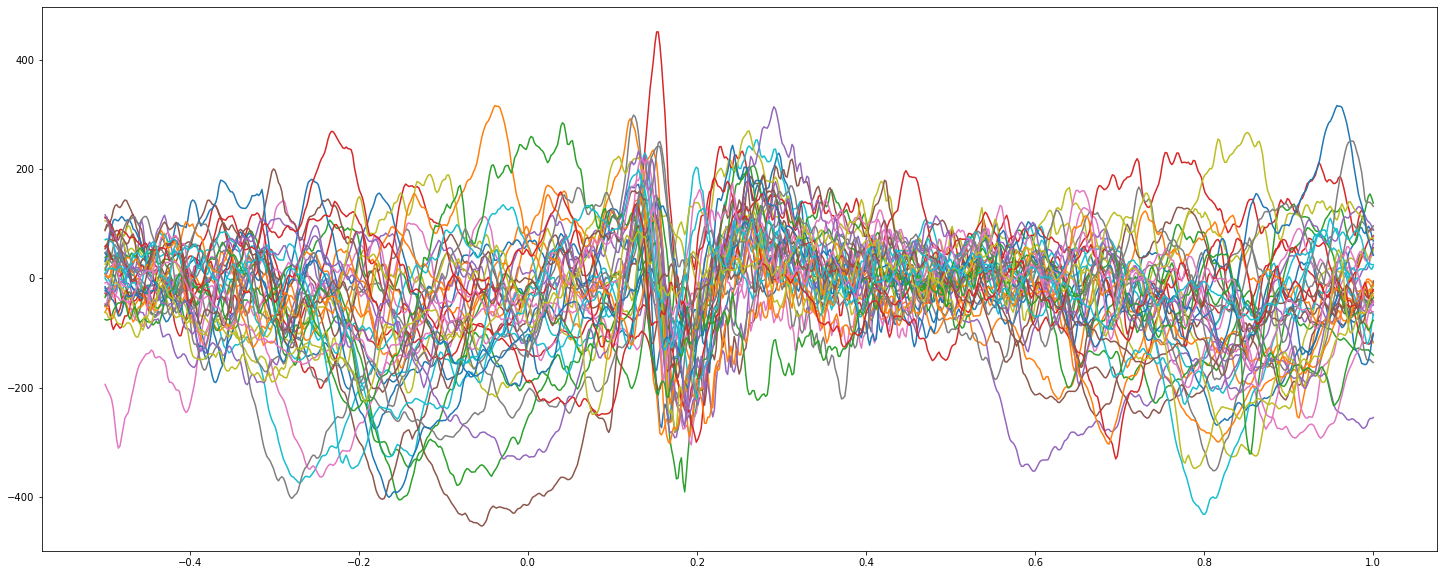

In [50]:
plot_trails(separate_signals,time)

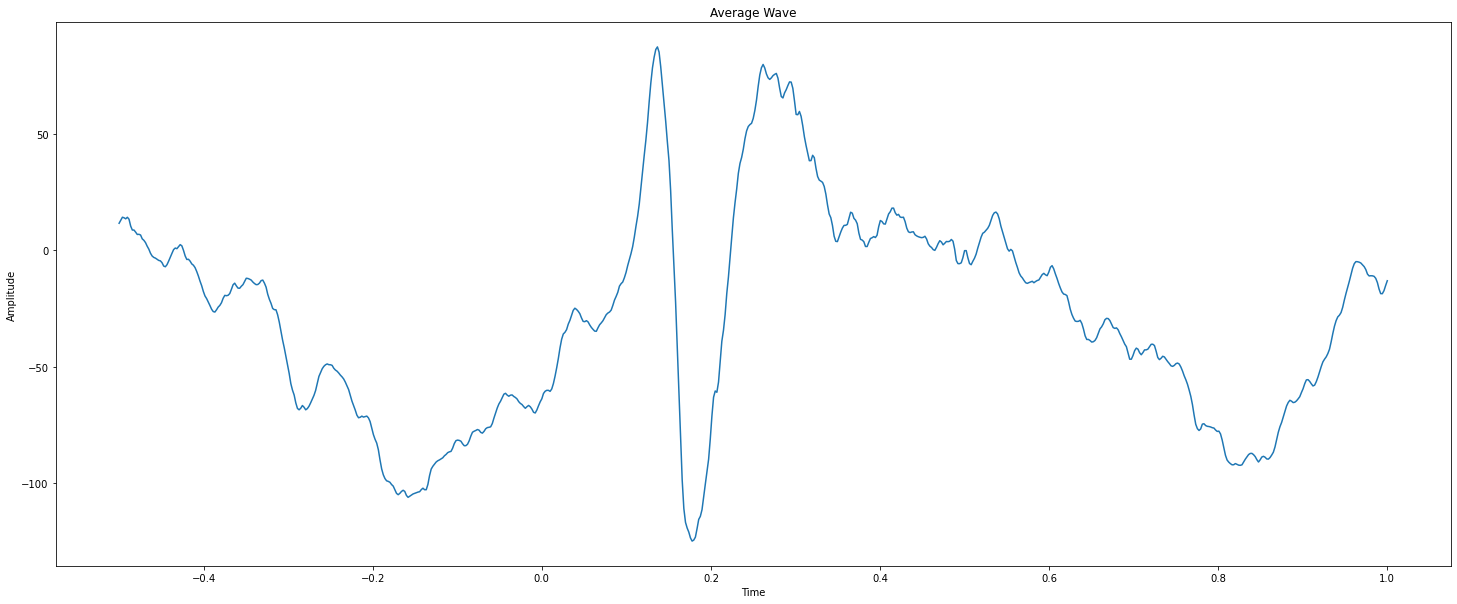

In [51]:
# plotting average wave
avg_wave = avg_trial(separate_signals)
plt.figure(figsize=(25,10))
plt.plot(time, avg_wave)
plt.title("Average Wave")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


2009.3791936250834


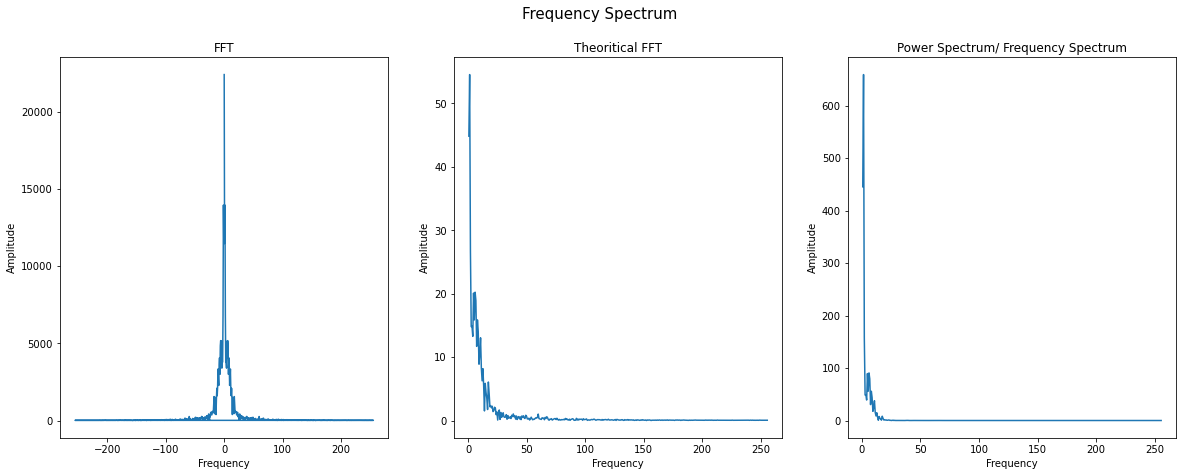

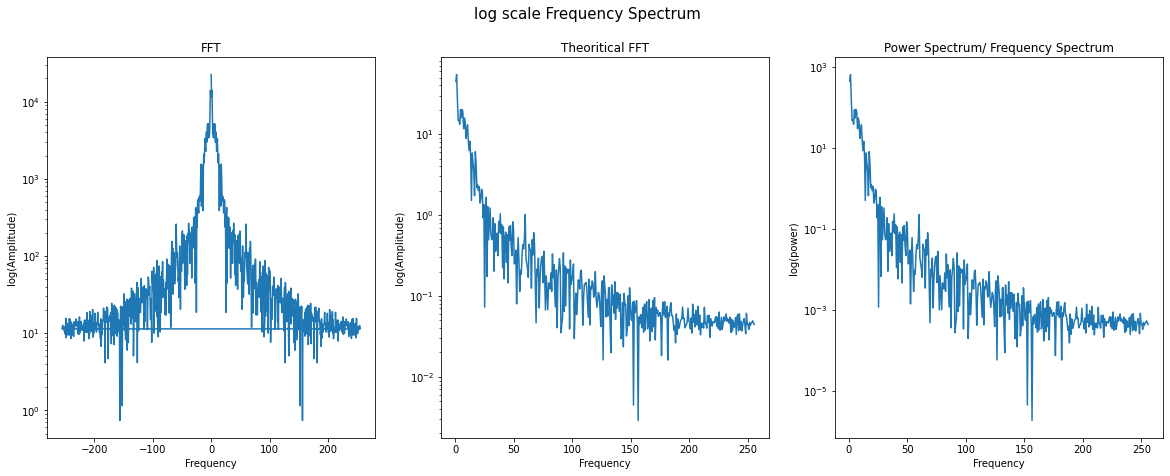

In [52]:
freqs,fft_vals,pos,fft_theo,ps = compute_spectra(avg_wave,fs,time)
plot_spectra(freqs,fft_vals,pos,fft_theo,ps)
logscale_spectrum_plot(freqs,fft_vals,pos,fft_theo,ps)

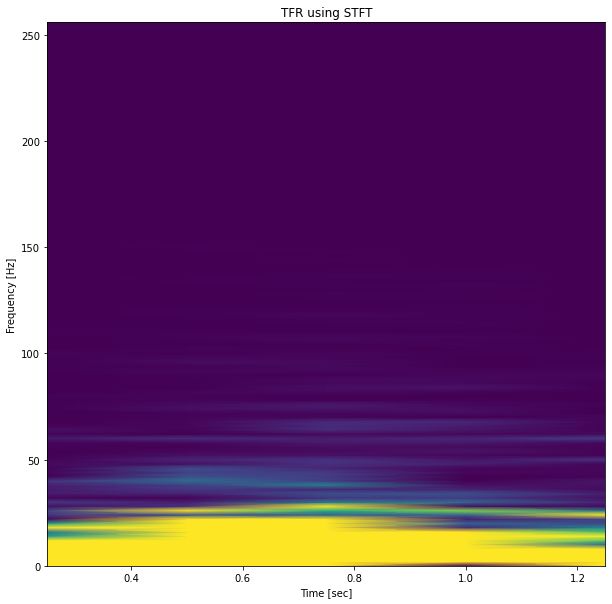

In [53]:
freqs, times, power = stft(avg_wave,fs)
plot_stft(freqs, times, power)

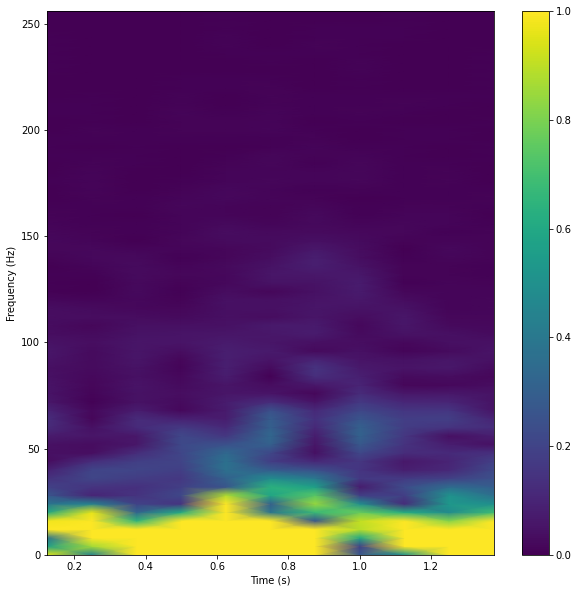

In [54]:
freqs, times, power = multitaper_transform(avg_wave,fs)
plot_multitaper(times, freqs, power)

## Condition2.mat dataset

In [55]:
mat_contents2 = sio.loadmat('Condition2.mat')
mat2 = mat_contents2['final_mat_condition7']
# print(type(mat_contents2)) 
# mat_contents2.items()
mat2.shape

(40, 769)

In [56]:
# separating trials
separate_signals2 = []
for i in range(0,mat2.shape[0]):
    separate_signals2.append(mat2[i,:])

In [57]:
fs = 512 # sampling frequency
end = 1  # end time
start = -0.5 # start time
time = np.arange(start,end+1/fs, step=1/fs)

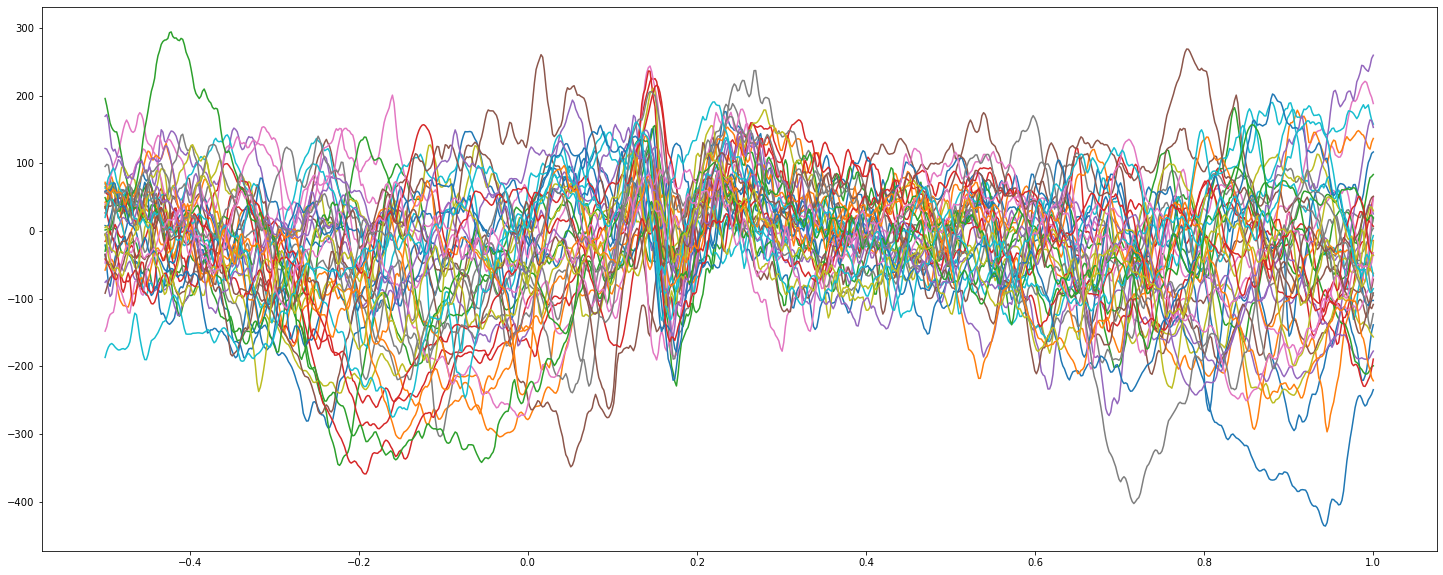

In [58]:
plot_trails(separate_signals2,time)

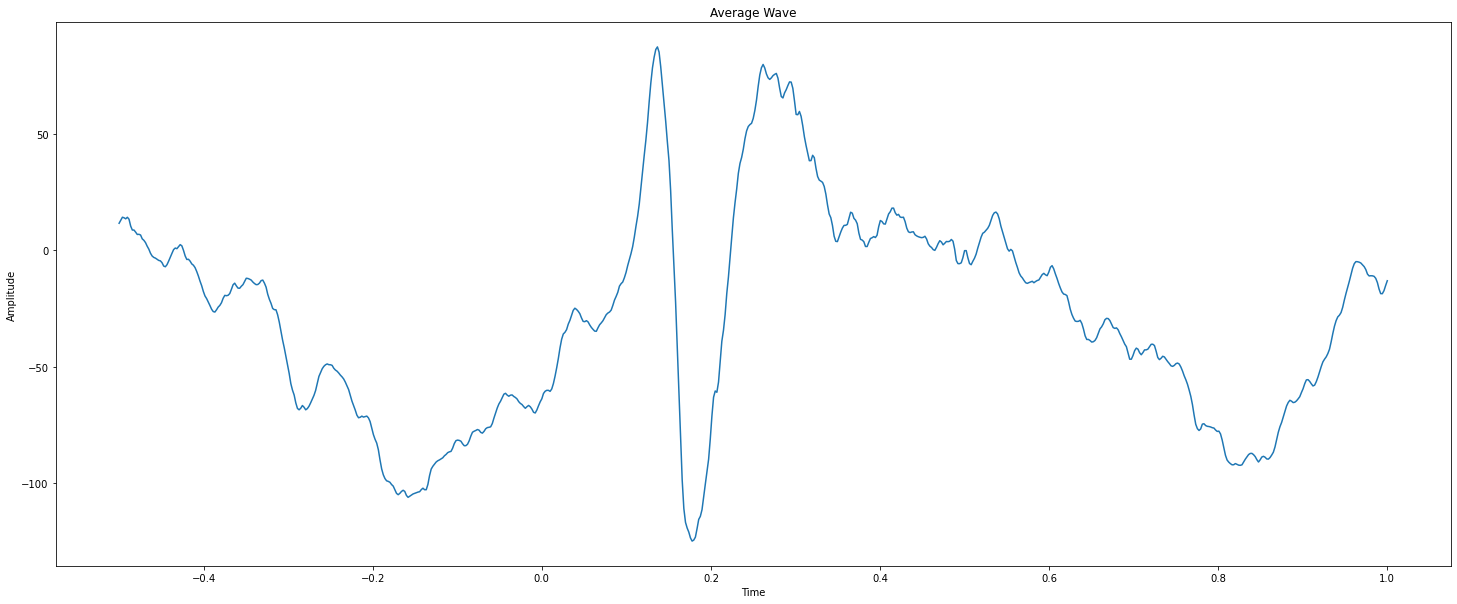

In [59]:
avg_wave2 = avg_trial(separate_signals2)
plt.figure(figsize=(25,10))
plt.plot(time, avg_wave)
plt.title("Average Wave")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

1273.4995622362055


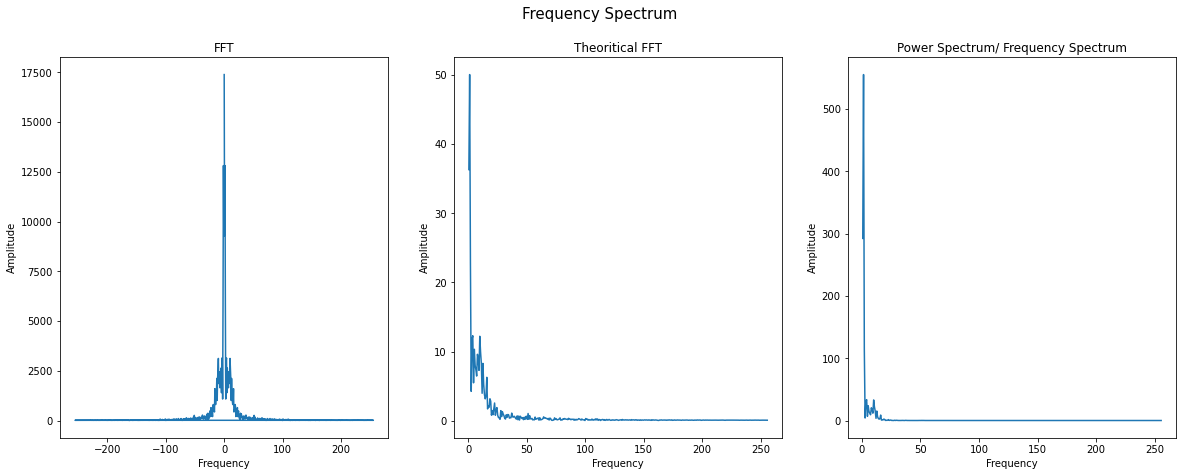

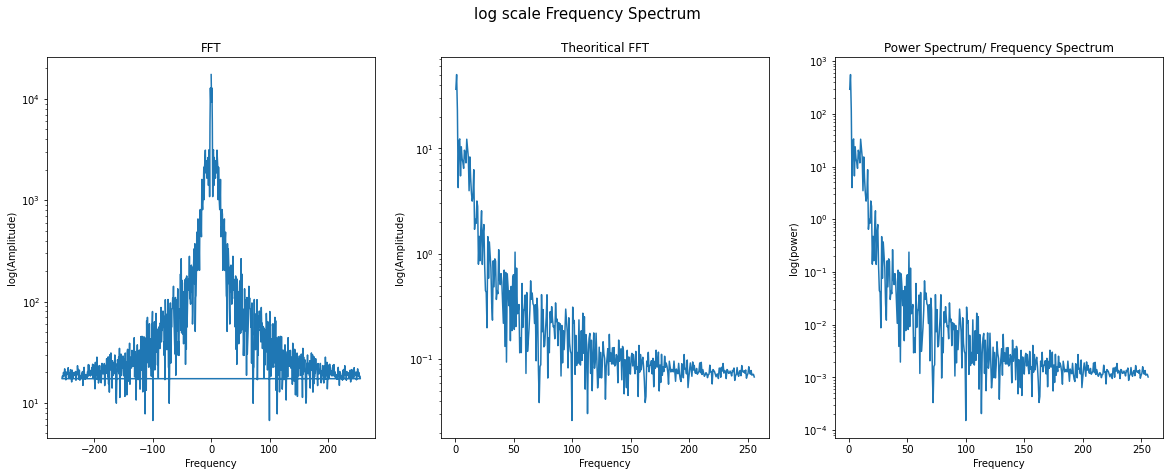

In [60]:
freqs,fft_vals,pos,fft_theo,ps = compute_spectra(avg_wave2,fs,time)
plot_spectra(freqs,fft_vals,pos,fft_theo,ps)
logscale_spectrum_plot(freqs,fft_vals,pos,fft_theo,ps)

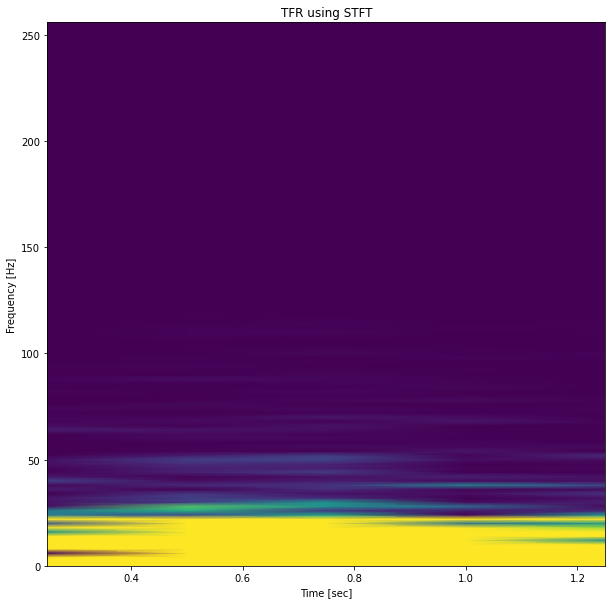

In [61]:
freqs, times, power = stft(avg_wave2,fs)
plot_stft(freqs, times, power)

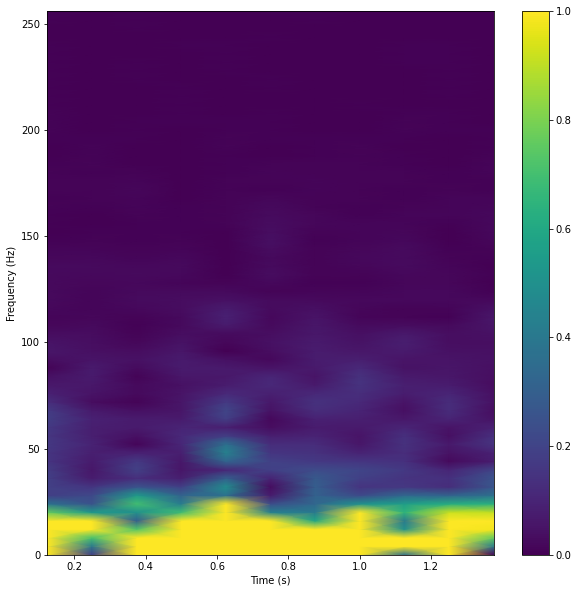

In [62]:
freqs, times, power = multitaper_transform(avg_wave2,fs)
plot_multitaper(times, freqs, power)